<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [2]:
!wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
!unzip -q img_align_celeba
!mkdir test
!mv img_align_celeba test

--2019-07-19 01:06:17--  https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.102, 172.217.214.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.17K  --.-KB/s    in 0s      

2019-07-19 01:06:18 (41.3 MB/s) - written to stdout [3241]

--2019-07-19 01:06:18--  https://docs.google.com/uc?export=download&confirm=wVEh&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 209.85.145.139, 209.85.145.100, 209.85.145.113, ...
Connecting to docs.google.com (docs.google.com)|209.85.145.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4epf4auknl43v7e2

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

In [0]:
class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
    
  def __getitem__(self,index):
    img = self.dataset_folder[index]
#     print(img[0])
    return img[0]

  def __len__(self):
    return len(self.dataset_folder)

---

## Part 0: Implement a generator network

---

One of the advantages of the “Improved WGAN Training” algorithm is that many different kinds of topologies can be used. For this lab, I recommend one of three options:

1. The DCGAN architecture, see Fig. 1.
2. A ResNet.
3. Our reference implementation used 5 layers:
> A fully connected layer
4 convolution transposed layers, followed by a batch norm layer and relu (except for the final layer)
Followed by a sigmoid (The true image is between 0 to 1 and you want your gen img to be between 0 and 1 too).
Don't use batch norms unless you want it to take longer

**TODO:**

* Create a generator

**DONE:**

In [0]:
class DCGAN_Generator(nn.Module):
  def __init__(self, latent_size):
    super(DCGAN_Generator, self).__init__()
    self.latent_size = latent_size
    # Fractionally strided convolutions
    self.net = nn.Sequential(
        # Go down by half the number of input feature maps but scale up by 2
        nn.Linear(self.latent_size, 16384),
        nn.LeakyReLU(.2)
    )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256, 128, (2, 2), padding=(0, 0), stride=2), # ->128*16*16
        nn.LeakyReLU(.2),
        nn.ConvTranspose2d(128, 64, (2, 2), padding=(0, 0), stride=2), # ->64*32*32
        nn.LeakyReLU(.2),
        nn.ConvTranspose2d(64, 32, (2, 2), padding=(0, 0), stride=2), # ->32*64*64
        nn.LeakyReLU(.2),
        nn.ConvTranspose2d(32, 3, (2, 2), padding=(0, 0), stride=2), # ->3*128*128
        nn.Sigmoid()
    )
    
  def forward(self, x):
    x = self.net(x)
    x = x.view(-1, 256, 8, 8)
    return self.conv(x)

---

## Part 1: Implement a discriminator network

---

Again, you are encouraged to use either a DCGAN-like architecture, or a ResNet.

Our reference implementation used 4 convolution layers, each followed by a batch norm layer and leaky relu (leak 0.2) No batch norm on the first layer. You can omit the batch norms to make it go faster

Note that the discriminator simply outputs a single scalar value. This value should unconstrained (ie, can be positive or negative), so you should not use a relu/sigmoid on the output of your network
**TODO:**

* Create a discriminator

**DONE:**

In [0]:
class DCGAN_Critic(nn.Module):
  def __init__(self, latent_size):
    super(DCGAN_Critic, self).__init__()
    self.latent_size = latent_size
    # Convolutions
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, (7, 7), padding=(0, 0)), # 3*128*128 -> 32*122*122
        nn.LeakyReLU(.2),
        nn.Conv2d(32, 64, (7, 7), padding=(0, 0)), # ->64*116*116
        nn.LeakyReLU(.2),
        nn.Conv2d(64, 128, (7, 7), padding=(0, 0)), # ->128*110*110
        nn.LeakyReLU(.2),
        nn.Conv2d(128, 256, (7, 7), padding=(0, 0)), # ->256*104*104
        nn.LeakyReLU(.2)
    )
    self.net = nn.Sequential(
        nn.Linear(256*104*104, 1)
    )
    
  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1,256*104*104)
    return self.net(x)

---

## Part 2: Implement the Improved Wasserstein GAN training algorithm

---

The implementation of the improved Wasserstein GAN training algorithm (hereafter called “WGAN-GP”) is fairly straightforward, but involves a few new details:

Gradient norm penalty. First of all, you must compute the gradient of the output of the discriminator with respect to x-hat. To do this, you should use the [autograd.grad](https://pytorch.org/docs/stable/autograd.html) function.
Reuse of variables. Remember that because the discriminator is being called multiple times, you must ensure that you do not create new copies of the variables. Use requires_grad = True for the parameters of the discriminator. An easier way to do this would be to iterate through the discriminator model parameters and set param.requires_grad = True
Trainable variables. In the algorithm, two different Adam optimizers are created, one for the generator, and one for the discriminator. You must make sure that each optimizer is only training the proper subset of variables!

**TODO:**

* Compute gradient norm penalty of the discriminator using autograd.grad


**DONE:**

* Don't create copies of variables (use requires_grad=True)
* Make sure the two optimizers only optimize their respective variables
 

In [0]:
# Initialize your generator and discriminator models
LATENT_SIZE = 100

def randomSample():
  return torch.as_tensor(np.random.random((1, LATENT_SIZE))).float()

def randomBatch(batch_size):
  return torch.as_tensor(np.random.random((batch_size, LATENT_SIZE))).float()

gen_model = DCGAN_Generator(LATENT_SIZE).cuda()
disc_model = DCGAN_Critic(LATENT_SIZE).cuda()

# Initialize separate optimizer for both gen and disc
# These parameters should work decently, adjust them to your liking
beta1 = 0.5 # 0
beta2 = 0.999 # 0.9
lambda_val = 10
ncritic = 5 # 5
learning_rate = 0.0002 # 0.0001
batch_size = 64


disc_optim = optim.Adam(disc_model.parameters(), lr=learning_rate, betas=(beta1, beta2))
gen_optim = optim.Adam(gen_model.parameters(), lr=learning_rate, betas=(beta1,beta2))
dobjective = nn.MSELoss()
gobjective = nn.MSELoss()

#initialize your dataset and dataloader
dataset = CelebaDataset('test')
# dataset[0]
BATCH_SIZE = 64
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, pin_memory=True)

---

##Part 3: Generating the final face images

---

Your final deliverable is two images. The first should be a set of randomly generated faces. This is as simple as generating random z variables, and then running them through your generator.

For the second image, you must pick two random z values, then linearly interpolate between them (using about 8-10 steps). Plot the face corresponding to each interpolated z value.

See the beginning of this lab spec for examples of both images.

**TODO:**

* Generate random faces
* Randomly interpolate between 2 random z values using 8-10 steps

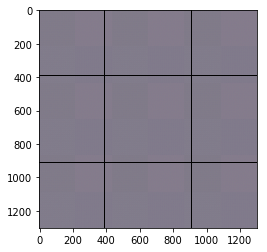

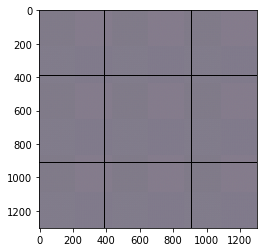

In [24]:
from torchvision.utils import make_grid 

def showMosaic(images):
  images = torch.cat(images, dim=0).cpu().detach()
  images = make_grid(images, nrow=10).numpy()
  plt.figure()
  plt.imshow(np.transpose(images, (1,2,0)))

def genRandomImages():
  return [gen_model(randomSample().cuda()).clone() for _ in range(100)]

def genInterpolationImages():
  images = []
  for i in range(10):
    first = randomSample()
    second = randomSample()
    gen_input = torch.zeros(1, LATENT_SIZE)
    for steps in range(10):
      for j in range(100):
        maxj = max(first[0][j], second[0][j])
        minj = min(first[0][j], second[0][j])
        diffj = maxj - minj
        gen_input[0][j] = minj + diffj*steps/10
      images.append(gen_model(gen_input.cuda()).clone())
  return images


showMosaic(genRandomImages())
showMosaic(genInterpolationImages())

In [0]:
start_from_scratch = False
epochs = 10
def scope():
  try:
    if os.path.isfile("gen_model.pt") and not start_from_scratch:
      print("Loading Models")
      gen_model.load_state_dict(torch.load("gen_model.pt"))
      disc_model.load_state_dict(torch.load("disc_model.pt"))
      print("Finished Loading Models")
    for e in range(epochs):
      for index, true_img in enumerate(data_loader):
        if index % 20 == 0:
          gc.collect()
          print("Memory Usage: {}".format(torch.cuda.memory_allocated(0) / 1e9))
        if index % 400 == 0:
          print("Saving Models")
          torch.save(gen_model.state_dict(), "gen_model.pt")
          torch.save(disc_model.state_dict(), "disc_model.pt")


        true_img = true_img.cuda(async=True)
        #train discriminator#

        #because you want to be able to backprop through the params in discriminator 
        for p in disc_model.parameters():
          p.requires_grad = True

        for p in gen_model.parameters():
          p.requires_grad = False

        for n in range(ncritic):
          disc_optim.zero_grad()

          # generate noise tensor z
          batch = randomBatch(true_img.size()[0]).cuda(async=True) # One batch 100 dimensions
          xtilde = gen_model(batch)
          xhat = batch_norm_epsilon*true_img + (1-batch_norm_epsilon*xtilde)
          # calculate disc loss: you will need autograd.grad
          # TODO: The rest of this
          xhat_auto = torch.autograd.Variable(xhat, requires_grad=True)
          disc_xhat = disc_model(xhat_auto)
    #       print("xhat {}".format(xhat_auto.size()))
    #       print("disc_xhat {}".format(disc_xhat.size()))
          gradients = torch.autograd.grad(disc_xhat, xhat_auto, torch.ones(disc_xhat.size()).cuda())[0]
          gradient_penalty = lambda_val*((gradients.norm(2, dim=1) - 1)**2).mean()
          disc_fake = disc_model(xtilde)
          disc_real = disc_model(true_img)
  #         print("disc_fake {}".format(disc_fake.size()))
  #         print("disc_real {}".format(disc_real.size()))
  #         print("gradient_penalty {}".format(gradient_penalty.size()))
          dloss = (disc_fake - disc_real + gradient_penalty).mean()
          # call dloss.backward() and disc_optim.step()
          dloss.backward()
          disc_optim.step()

        #train generator#
        for p in disc_model.parameters():
          p.requires_grad = False

        for p in gen_model.parameters():
          p.requires_grad = True

        gen_optim.zero_grad()

        # generate noise tensor z
        batch = randomBatch(true_img.size()[0]).cuda(async=True) # One batch 100 dimensions
        # calculate loss for gen
        gloss = (-disc_model(gen_model(batch))).mean()
        # call gloss.backward() and gen_optim.step()
        gloss.backward()
        gen_optim.step()
  except Exception as e:
    print(e)
      

scope()
showMosaic(genRandomImages())
showMosaic(genInterpolationImages())

Memory Usage: 3.027303424
Saving Models
Memory Usage: 3.14641408


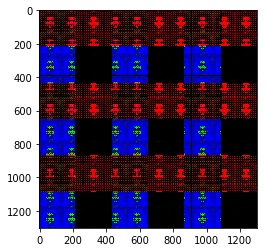

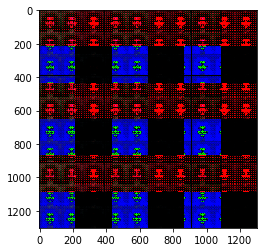

In [15]:
showMosaic(genRandomImages())
showMosaic(genInterpolationImages())